# 🕺 Human Pose Estimation using Deep Learning

## Overview
This notebook demonstrates how to detect human body keypoints (joints) such as elbows, knees, and shoulders using **OpenCV’s Deep Neural Network (DNN) module**.  
We utilize pre-trained models based on the **OpenPose approach**, and perform inference on single-person images to visualize detected keypoints and skeleton connections.  
Matplotlib is used for visualization of both probability maps and the final skeleton overlay.

## Objectives
- Load and preprocess input images for pose estimation.
- Download and load pre-trained human pose models (Caffe-based OpenPose).
- Perform forward pass through the DNN to obtain keypoint confidence maps.
- Extract body keypoints and scale them to the original image dimensions.
- Visualize detected keypoints and draw skeleton connections.
- Display probability maps to understand model confidence for each joint.

## Key Learnings
- Understanding human pose estimation and the concept of body keypoints.
- Preprocessing images for deep learning inference using OpenCV’s `blobFromImage`.
- Using OpenCV DNN module to load Caffe models and perform forward passes.
- Extracting and scaling keypoints from probability maps.
- Drawing skeletons by connecting keypoints using defined pose pairs.
- Visualizing model outputs including keypoints, skeleton, and probability maps.

## Tools & Libraries
- **OpenCV**: Reading images, preprocessing, deep learning inference, drawing keypoints and skeletons.
- **NumPy**: Handling image arrays and numerical operations.
- **Matplotlib**: Visualizing images, keypoints, skeletons, and probability maps.
- **Urllib / OS**: Downloading and managing pre-trained model files.


---

- **What is Pose Estimation?**  
Pose estimation refers to detecting human body keypoints (joints) such as elbows, knees, and shoulders in an image or video.  

- **Applications:**  
  - Activity recognition  
  - Human-computer interaction  
  - AR/VR & gaming  
  - Sports analytics  

- **Approach in this Notebook:**  
We will use **OpenCV's Deep Neural Network (DNN) module** with pre-trained models (based on the **OpenPose** approach) to perform multi-joint detection.  


# Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields (2017)
arXiv:1611.08050v2 [cs.CV] 14 Apr 2017
![Open_Pose](data/OpenPose_Figure.png)

## 🔎 Highlights

1. **Train elsewhere, run inference in OpenCV**  
   - OpenCV enables you to use pre-trained deep learning models for inference without retraining.  

2. **Framework Support**  
   - Compatible with: **Caffe**, **TensorFlow**, **Torch**, and **Darknet**.  

3. **Supported Layers**  
   - `AbsVal`, `AveragePooling`, `BatchNormalization`, `Concatenation`, `Convolution (incl. dilated conv)`,  
   - `Crop`, `Deconvolution`, `DetectionOutput (SSD)`, `Dropout`, `Eltwise (+, *, max)`,  
   - `Flatten`, `FullyConnected`, `LRN`, `LSTM`, `MaxPooling`, `MaxUnpooling`,  
   - `MVN`, `NormalizeBBox (SSD)`, `Padding`, `Permute`, `Power`,  
   - `PReLU (incl. ChannelPReLU)`, `PriorBox (SSD)`, `ReLU`, `RNN`,  
   - `Scale`, `Shift`, `Sigmoid`, `Slice`, `Softmax`, `Split`, `TanH`.  

4. **Model Used in this Notebook**  
   - Pre-trained **Caffe model** (on the **MPII dataset**)  
   - Demonstrates **human pose estimation for a single person**.


In [1]:
from IPython.display import HTML
HTML("""
<video width=1024 controls>
  <source src="data/Ice_Hockey.mp4" type="video/mp4">
</video>
""")

In [2]:
# 📦 Import Required Libraries

import cv2                     # OpenCV for computer vision & deep learning inference
import time                    # Measure execution time & FPS
import numpy as np             # Numerical computations & matrix operations
import matplotlib.pyplot as plt # Visualization and plotting
import os                      # File and directory operations
import urllib                  # Downloading pre-trained models from the web


## 📥 Load a Caffe Model

A typical **Caffe model** consists of two essential files:

1. **Architecture (`.prototxt`)**  
   - Defines the model structure (layers, connections, operations).  

2. **Weights (`.caffemodel`)**  
   - Stores the learned parameters from training (filters, biases, etc.).  

In this notebook, we will use both files to load a pre-trained model for **human pose estimation**.


In [3]:
# -----------------------------------------------------------
# 🔽 Download Human Pose Estimation (MPI) Model (if not exists)
# -----------------------------------------------------------

# Create a folder to store model weights (if not already present)
if not os.path.isdir("models"):
    os.mkdir("models")

# File paths for model architecture & weights
protoFile = "pose_deploy_linevec_faster_4_stages.prototxt"     # Defines network layers (architecture)
weightsFile = "models/pose_iter_160000.caffemodel"             # Contains trained weights

# Download architecture file (.prototxt) if missing
if not os.path.isfile(protoFile):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt",
        protoFile
    )

# Download weights file (.caffemodel) if missing
if not os.path.isfile(weightsFile):
    urllib.request.urlretrieve(
        "http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel",
        weightsFile
    )

print("✅ Human Pose Estimation model files are ready.")


✅ Human Pose Estimation model files are ready.


In [4]:
# -----------------------------------------------------------
# 🎯 Load Human Pose Estimation Model & Define Keypoints
# -----------------------------------------------------------

# Total number of keypoints (MPI dataset defines 15 body joints)
nPoints = 15

# Pairs of keypoints to connect (to draw skeleton structure)
POSE_PAIRS = [
    [0,1], [1,2], [2,3], [3,4],       # Right Arm
    [1,5], [5,6], [6,7],              # Left Arm
    [1,14], [14,8], [8,9], [9,10],    # Right Leg
    [14,11], [11,12], [12,13]         # Left Leg
]

# Load the pre-trained network from Caffe model files
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

print("✅ Human Pose Estimation model loaded successfully.")


✅ Human Pose Estimation model loaded successfully.


# 📷 Read Input Image

In [6]:
# Load the input image
im = cv2.imread("data/Tiger_Woods_crop.png")

# Convert from BGR (OpenCV default) to RGB (for matplotlib display)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Get image dimensions
inWidth = im.shape[1]   # Image width
inHeight = im.shape[0]  # Image height

print(f"✅ Image loaded: {inWidth}x{inHeight}")

✅ Image loaded: 842x844


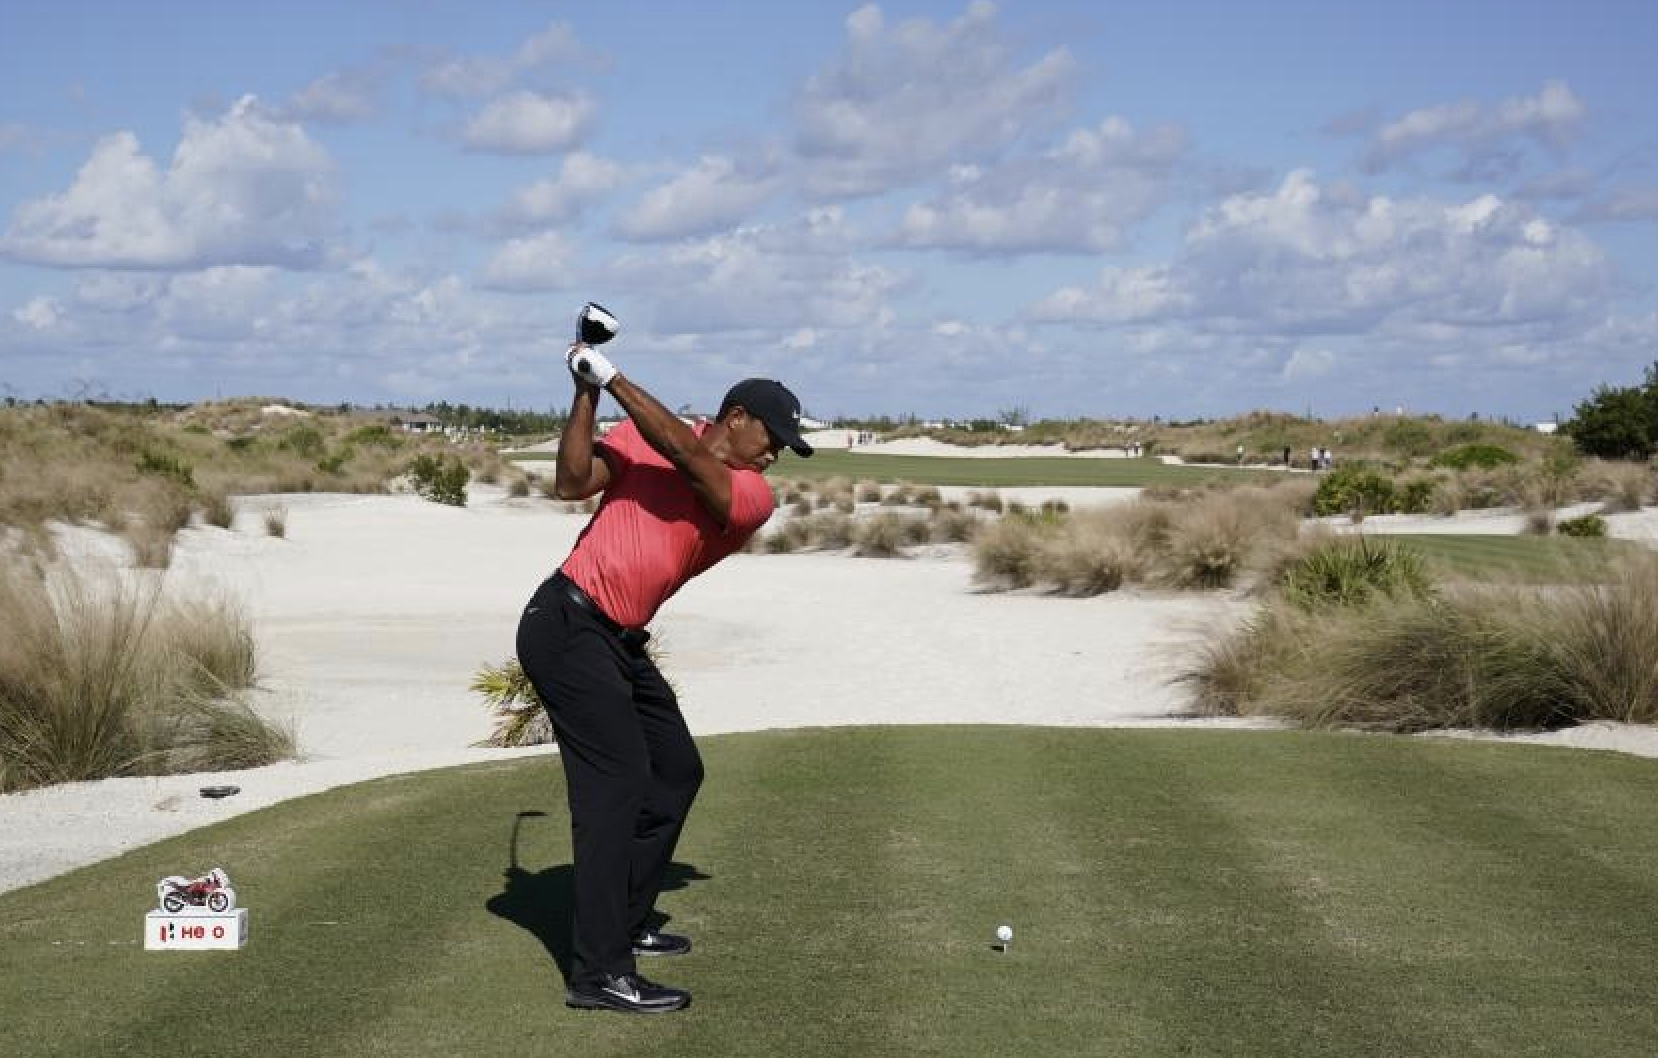

In [7]:
from IPython.display import Image
Image(filename='data/Tiger_Woods.png') 

# 🧾 Convert Image to Blob (Preprocessing for the DNN)

In [8]:
# Define the network input size (commonly used for OpenPose MPI model)
netInputSize = (368, 368)

# Convert the image into a blob that can be fed to the network
# - Scaling factor: 1.0/255 → normalize pixel values to [0,1]
# - Size: netInputSize → resize image to expected input
# - Mean subtraction: (0,0,0) → no mean subtraction here
# - swapRB=True → convert from RGB to BGR (since OpenCV uses BGR by default)
# - crop=False → resize without cropping
inpBlob = cv2.dnn.blobFromImage(
    im, 
    1.0 / 255, 
    netInputSize, 
    (0, 0, 0), 
    swapRB=True, 
    crop=False
)

# Set the blob as input to the network
net.setInput(inpBlob)

print("✅ Image converted to blob and set as network input.")


✅ Image converted to blob and set as network input.


# ▶️ Run Inference (Forward Pass) and Visualize Probability Maps

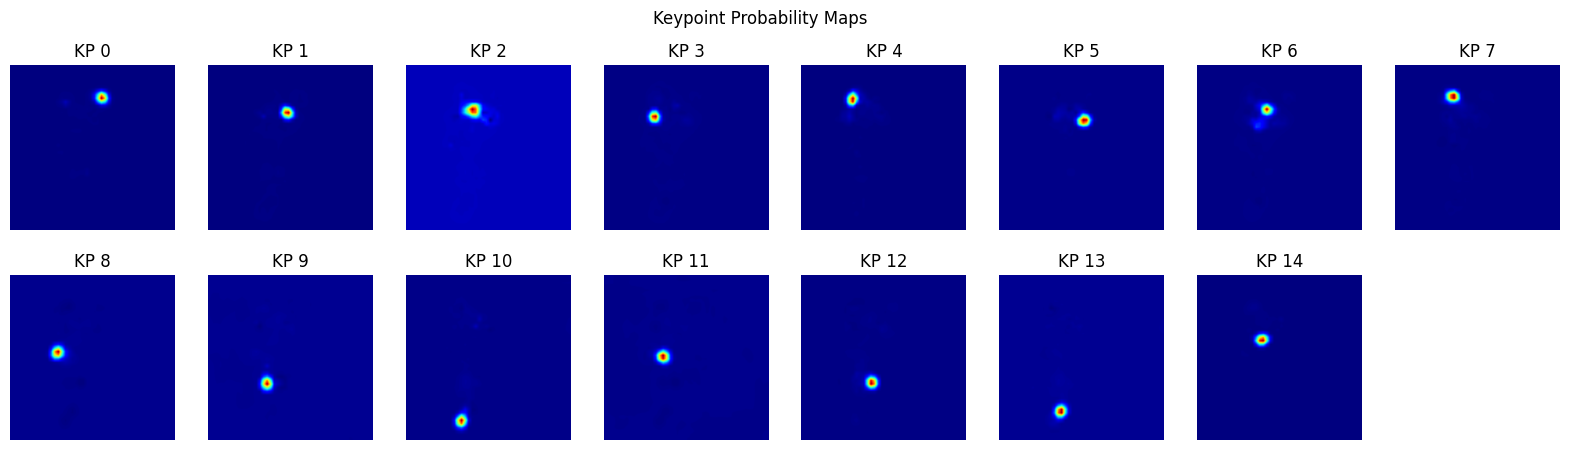

In [9]:
# Perform forward pass through the network to get keypoint confidence maps
output = net.forward()

# Display probability maps for each keypoint
plt.figure(figsize=(20,5))

for i in range(nPoints):
    # Extract the confidence map of the i-th keypoint
    probMap = output[0, i, :, :]
    
    # Resize probability map to match original image dimensions
    displayMap = cv2.resize(probMap, (inWidth, inHeight), interpolation=cv2.INTER_LINEAR)
    
    # Plot the confidence map
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    plt.imshow(displayMap, cmap='jet')
    plt.title(f'KP {i}')

plt.suptitle("Keypoint Probability Maps")
plt.show()


# 📌 Extract Keypoints from Probability Maps

In [10]:
# Compute scaling factors to map points back to original image size
scaleX = inWidth / output.shape[3]   # Width scaling
scaleY = inHeight / output.shape[2]  # Height scaling

# List to store detected keypoints
points = []

# Confidence threshold for detecting keypoints
threshold = 0.1

# Loop through each keypoint
for i in range(nPoints):
    # Extract the probability map for the i-th keypoint
    probMap = output[0, i, :, :]
    
    # Find the global maximum of the probability map
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point coordinates to the original image
    x = scaleX * point[0]
    y = scaleY * point[1]

    # Keep the point only if its probability exceeds the threshold
    if prob > threshold:
        points.append((int(x), int(y)))
    else:
        points.append(None)

print("✅ Keypoints extracted successfully.")


✅ Keypoints extracted successfully.


# 🖼️ Display Keypoints and Skeleton

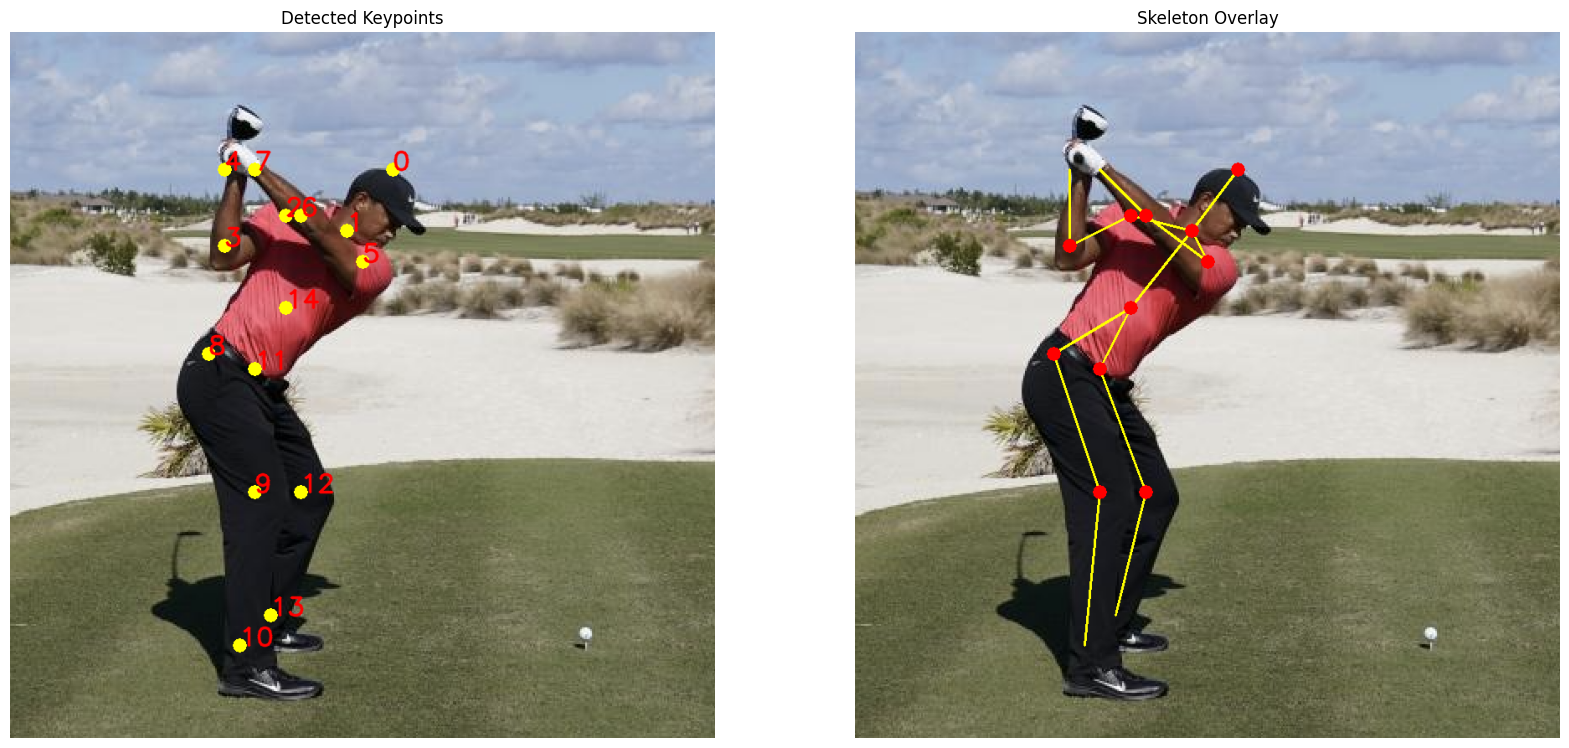

In [11]:
# Make copies of the original image for drawing
imPoints = im.copy()     # For displaying keypoints
imSkeleton = im.copy()   # For displaying the skeleton connections

# --------------------------
# Draw Keypoints
# --------------------------
for i, p in enumerate(points):
    if p:  # Only draw if the keypoint was detected
        cv2.circle(imPoints, p, 8, (255, 255, 0), thickness=-1, lineType=cv2.FILLED)  # Draw circle
        cv2.putText(imPoints, "{}".format(i), p, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, lineType=cv2.LINE_AA)  # Label keypoints

# --------------------------
# Draw Skeleton
# --------------------------
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    # Draw line only if both keypoints exist
    if points[partA] and points[partB]:
        cv2.line(imSkeleton, points[partA], points[partB], (255, 255, 0), 2)         # Skeleton line
        cv2.circle(imSkeleton, points[partA], 8, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)  # Optional: keypoint circles

# Display the results using Matplotlib
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("Detected Keypoints")
plt.imshow(imPoints)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Skeleton Overlay")
plt.imshow(imSkeleton)
plt.axis("off")

plt.show()
